Preprocess ERA-Land SM

ERA5-Land gives the soil moisture values in a 9km*9km grid over Great Britain (download from Copernicus). This script takes those values and average the results over the area of a basin. The script recieves the ERA5-Land value as a .nc and the basin areas as a .shp

Original script by Lees (https://doi.org/10.5194/hess-26-3079-2022)
https://github.com/tommylees112/neuralhydrology/blob/pixel/notebooks/05b_preprocess_era5.ipynb
https://zenodo.org/record/5600851

We did some adaptations to use the script for our own purposes.

In [1]:
#Import necessary packages
import os
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import xarray as xr 
import rasterio

from pathlib import Path
from clip_netcdf_to_shapefile import prepare_rio_data
from clip_netcdf_to_shapefile import (create_camels_basin_timeseries)

Part 1. Generate the basin-average soil moisture series

In [2]:
# Reference the information
path_shp = Path("../data/Catchment_Boundaries/Selected_Basins_hybrid.shp")
path_to_sm_data = Path("../data/gb_soil_moisture_1234_snow.nc")
# Folder to store the results
save_folder = Path("../results/soil_moisture")

In [3]:
# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(save_folder):
    # Create the folder
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' created successfully.")
else:
    print(f"Folder '{save_folder}' already exists.")

Folder '..\results\soil_moisture' created successfully.


In [4]:
# Read the ERA5-Land product
sm = xr.open_dataset(path_to_sm_data).sortby("time").rename({"latitude": "lat", "longitude": "lon"})
sm # the dimensions (87*93*14244) is because there are 87 latitude pixels, 93 longitude pixels and 14244 days (01/01/1981-31/12/2019)

<xarray.Dataset>
Dimensions:  (lat: 87, lon: 93, time: 14244)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
  * lat      (lat) float32 58.56 58.46 58.36 58.26 ... 50.26 50.16 50.06 49.96
  * lon      (lon) float32 -7.57 -7.47 -7.37 -7.27 -7.17 ... 1.33 1.43 1.53 1.63
Data variables:
    swvl1    (time, lat, lon) float32 ...
    swvl2    (time, lat, lon) float32 ...
    swvl3    (time, lat, lon) float32 ...
    swvl4    (time, lat, lon) float32 ...
    sd       (time, lat, lon) float32 ...

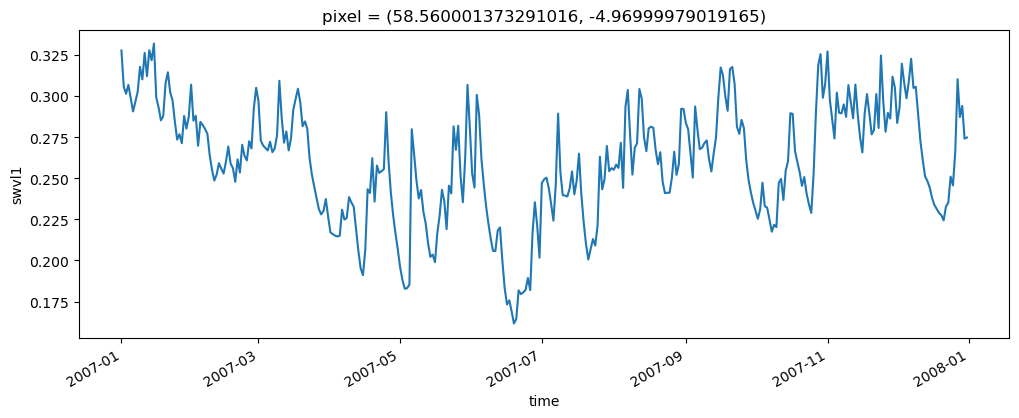

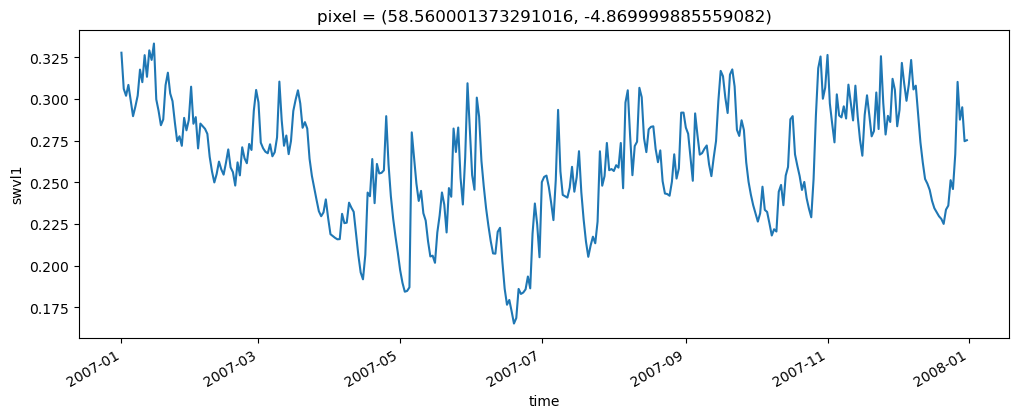

In [5]:
# Plot some swvl1 (soil water volume level 1) series to see if they were upload correctly
plot = sm[["swvl1"]].dropna(dim="lon", how="all").dropna(dim="lat", how="all")
pixels = plot.stack(pixel=["lat", "lon"]).dropna("pixel", how="all")
choices = pixels.pixel.values[0:2]

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    pixels.sel(pixel=px)["swvl1"].sel(time="2007").plot(ax=ax)

In [6]:
# This part is the one that process the ERA5-Land data, and average the pixel values over the catchment area to have one basin-average value
outfilepath = save_folder / 'camels_basin_ERA5Land_sm.nc'
if not outfilepath.exists():
    era5_sm = create_camels_basin_timeseries(data_obj=path_to_sm_data, shp_data_dir=path_shp , lat_dim="latitude", lon_dim="longitude")
    era5_sm["station_id"] = era5_sm.station_id.astype("int64")
    era5_sm = era5_sm.sortby("time")
    
    # save the catchment averaged timeseries of soil moisture
    era5_sm.to_netcdf(outfilepath)
else:
    era5_sm = xr.open_dataset(outfilepath)
    
era5_sm

Rasterising Geometry: : 60it [00:00, 126.17it/s, 9002] 
Chopping ROI: 100%|██████████| 60/60 [10:00<00:00, 10.02s/it, 9002] 


<xarray.Dataset>
Dimensions:      (station_id: 60, time: 14244)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
    spatial_ref  int32 0
  * station_id   (station_id) int64 10003 11001 11003 12001 ... 8005 8006 9002
Data variables:
    swvl1        (station_id, time) float32 0.349 0.3731 ... 0.2965 0.2845
    swvl2        (station_id, time) float32 0.3551 0.3579 ... 0.287 0.2906
    swvl3        (station_id, time) float32 0.3748 0.3734 ... 0.2933 0.2921
    swvl4        (station_id, time) float32 0.3794 0.3793 ... 0.3065 0.3064
    sd           (station_id, time) float32 0.0002257 0.0007096 ... 0.0 0.0

In [7]:
# Store the soil moisture series for all basins in a dataframe 
filepath = save_folder / 'camels_basin_ERA5Land_sm.nc'
dataset=xr.open_dataset(filepath)
swvl3_data = dataset["swvl3"] # get the variable of interest (swvl3) for all stations
df_swvl3 = pd.DataFrame() # create an empty dataframe

# Iterate over each station_id
for station_id in dataset["station_id"]:
    # Extract the values for the current station_id
    swvl3_values = swvl3_data.sel(station_id=station_id, 
                                  time=slice(pd.to_datetime('2006-10-01'), pd.to_datetime('2012-09-30')))
    
    # Convert the xarray DataArray to a pandas Series
    swvl3_series = swvl3_values.to_series()
    
    # Add the series to the dataframe with station_id as the column name
    df_swvl3[str(station_id.values)] = swvl3_series

# Seve in csv
df_swvl3.to_csv(save_folder / 'Era5_swvl3.csv', index=True)

Part 2. Generate a .tif file of the soil moisture across Great Britain (used in a Figure)

In [8]:
# Load shapefile and dataset
gdf = gpd.read_file(path_shp)
ds = xr.open_dataset(path_to_sm_data)

# Ensure that data properly initialised (e.g. CRS is the same)
ds, gdf = prepare_rio_data(ds, gdf, lat_dim="latitude", lon_dim="longitude")


time_index = 0 # Specify time to plot
variable_name = 'swvl3' # Select the variable to plot
data_for_time = ds[variable_name].isel(time=time_index)

# Specify the file name and path for the output .tif file
output_tif_filename = save_folder / 'ERA5Land_swvl3.tif'

# Specify the x and y coordinates for the upper-left corner of the image
x_ul = data_for_time.longitude.values[0]
y_ul = data_for_time.latitude.values[0]

# Calculate the pixel size (resolution) in degrees
pixel_size_x = data_for_time.longitude.values[1] - data_for_time.longitude.values[0]
pixel_size_y = data_for_time.latitude.values[0] - data_for_time.latitude.values[1]

# Prepare the transform for the .tif file
transform = rasterio.transform.from_origin(x_ul, y_ul, pixel_size_x, pixel_size_y)

# Create the .tif file
with rasterio.open(
    output_tif_filename,
    'w',
    driver='GTiff',
    height=data_for_time.shape[0],  # Number of rows (latitude dimension)
    width=data_for_time.shape[1],   # Number of columns (longitude dimension)
    count=1,  # Number of bands (1 for this case)
    dtype=data_for_time.values.dtype,  # Data type of the values
    crs="EPSG:4326",  # Coordinate reference system (WGS 84)
    transform=transform,
    nodata=-9999,  # Specify the NoData value
) as dst:
    dst.write(data_for_time.values, 1)  # Write the data to the .tif file

print(f"Successfully created {output_tif_filename}")

Successfully created ..\results\soil_moisture\ERA5Land_swvl3.tif
